In [ ]:
# from metabase_api import Metabase_API

########
# csv 읽기
# 그대로 db에 집어넣기까지 한 뒤, 아래의 소스를 붙여넣고 전체 소스 완성
########

# 메타베이스에서 데이터 뽑아오기
# mb = Metabase_API('http://localhost:3000/', 'shirakawataka@gmail.com', 'test1234@')

# out = mb.post('/api/card/8/query/json')

# df = pd.DataFrame.from_records(out)

In [2]:
import pandas as pd
from sklearn import linear_model as lm
import sklearn.model_selection
from matplotlib import pyplot as plt
import numpy as np
import pymysql

In [3]:
# 아니면 DB에서 직접 뽑아오는 방법도 존재함. 아래의 SQL을 사용
conn = pymysql.connect(
    user = 'taka',
    password = '1004',
    host = '127.0.0.1',
    database ='vist',
    charset = 'utf8'
)

sql = "SELECT str_to_date(concat(date_format(`vistp`.`check_date`,'%Y-%m'),'-01'),'%Y-%m-%d')AS `check_date`,sum(`vistp`.`booking`)AS `sum`, sum(`vistp`.`nb_visit`)AS `sum_2`, sum(`vistp`.`nb_visit`)AS `sum_3`,  sum(`vistp`.`totvisit`) AS sum_4 FROM vistp GROUP BY str_to_date(concat(date_format(`vistp`.`check_date`,'%Y-%m'),'-01'),'%Y-%m-%d')ORDER BY str_to_date(concat(date_format(`vistp`.`check_date`,'%Y-%m'),'-01'),'%Y-%m-%d')ASC"

with conn:
    with conn.cursor() as cur:
        cur.execute(sql)
        result = cur.fetchall()
        for data in result:
            print(data)
        
        df = pd.DataFrame.from_records(result)
            
print(df.head())

(datetime.date(2017, 1, 1), Decimal('1600'), Decimal('20748'), Decimal('20748'), Decimal('22348'))
(datetime.date(2017, 2, 1), Decimal('760'), Decimal('30854'), Decimal('30854'), Decimal('31614'))
(datetime.date(2017, 3, 1), Decimal('1600'), Decimal('24019'), Decimal('24019'), Decimal('25619'))
(datetime.date(2017, 4, 1), Decimal('11612'), Decimal('36054'), Decimal('36054'), Decimal('47666'))
(datetime.date(2017, 5, 1), Decimal('8464'), Decimal('54084'), Decimal('54084'), Decimal('62498'))
(datetime.date(2017, 6, 1), Decimal('8096'), Decimal('32675'), Decimal('32675'), Decimal('40771'))
(datetime.date(2017, 7, 1), Decimal('4005'), Decimal('29237'), Decimal('29237'), Decimal('33167'))
(datetime.date(2017, 8, 1), Decimal('2949'), Decimal('44261'), Decimal('44261'), Decimal('47210'))
(datetime.date(2017, 9, 1), Decimal('6079'), Decimal('27256'), Decimal('27256'), Decimal('33259'))
(datetime.date(2017, 10, 1), Decimal('7036'), Decimal('30835'), Decimal('30835'), Decimal('37853'))
(datetime

In [ ]:
df.columns

In [4]:
# 인덱스 지정 check_date 를 유니크 값으로 간주 가능
# 결측치는 존재하지 않으므로 처리 할 필요가 없음.
# 일일 데이터의 휴관일 등으로 인한 관람객 0명은 월 합계에서 무시되는 값이기 때문.

# 필요한 데이터만 정제해봄

df = df.drop(df.columns[[1,2,3]], axis=1)

# 총 입장객 수를 가지고, 2018년 1월의 입장객 예측 데이터를 뽑아보려고 함
# 총 입장객 수의 칼럼명 변경

df.columns = ['check_date', 'tot']
print(df.head())

year_months = list(df['check_date'].unique())
pred_data = pd.DataFrame()

# 2017년 7월부터 뽑아야하므로 인덱스번호 6부터
for i in range(6, len(year_months)):
    # 해당 월 하나씩 뽑아서 임시 데이터 프레임에 저장
    tmp = df.copy()
    tmp = tmp.loc[df['check_date'] == year_months[i]]
    # tmp의 tot를 tot_pred로 변경 (예측하고자 하는 정답 데이터)
    tmp.rename(columns={'tot': 'tot_pred'}, inplace=True)
    # 데이터 병합을 위해, 현재 데이터 수집 중인 연월을 저장
    nowDate = year_months[i]

    # 그리고 tmp 하나의 달에 대응하는 이전 6개월 분의 데이터를 만듦
    for j in range(1,7):
        tmp_before = df.copy()
        tmp_before = tmp_before.loc[df['check_date'] == year_months[i-j]]

        # 과거 6개월의 데이터를 채우기 때문에 tot0부터 6까지의 열이 만들어짐
        tmp_before.rename(columns={'tot': 'tot_{}'.format(j-1)}, inplace=True)
        tmp_before.loc[i-j, 'check_date'] = nowDate

        # 그리고 tmp와 tmp_before를 결합
        tmp = pd.merge(tmp, tmp_before, on='check_date', how='left')

    # 결합 후, 비어있는 pred_data에 tmp를 하나하나 결합시킴
    pred_data = pd.concat([pred_data, tmp], ignore_index=True)

print(pred_data)

   check_date    tot
0  2017-01-01  22348
1  2017-02-01  31614
2  2017-03-01  25619
3  2017-04-01  47666
4  2017-05-01  62498
   check_date tot_pred  tot_0  tot_1  tot_2  tot_3  tot_4  tot_5
0  2017-07-01    33167  40771  62498  47666  25619  31614  22348
1  2017-08-01    47210  33167  40771  62498  47666  25619  31614
2  2017-09-01    33259  47210  33167  40771  62498  47666  25619
3  2017-10-01    37853  33259  47210  33167  40771  62498  47666
4  2017-11-01    26503  37853  33259  47210  33167  40771  62498
5  2017-12-01    27164  26503  37853  33259  47210  33167  40771


1.0
-6.306025092338872


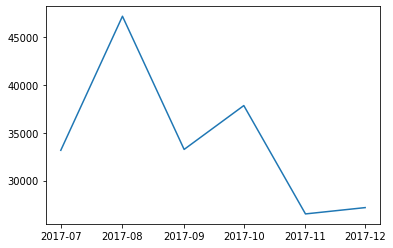

In [6]:
model = lm.LinearRegression()

# 학습 할 독립 변수
X = pred_data[['tot_0', 'tot_1', 'tot_2', 'tot_3', 'tot_4', 'tot_5']]
# 학습 할 종속 변수
y = pred_data['tot_pred']

# 학습 시키기
# 먼저 train과 test set을 나눔
# 디폴트로는 train:test를 75:25로 분할
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

# 검증?
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

# 그래프 그리기

x = np.arange('2017-07', '2018-01', dtype='datetime64[M]')
yy = y.values.tolist()

plt.plot(x, yy)
plt.show()